In [ ]:
from jax import random
from sklearn.datasets import make_spd_matrix
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os

data_dim=8
sample_size=10
threshold_missing=0.5

def is_latexify_enabled():
    """
    returns true if LATEXIFY environment variable is set
    """
    return "LATEXIFY" in os.environ


def _get_fig_name(fname_full):
    fname_full = fname_full.replace("_latexified", "")
    LATEXIFY = "LATEXIFY" in os.environ
    # extention = "_latexified.pdf" if LATEXIFY else ".png"
    extention = "_latexified.pdf" if LATEXIFY else ".pdf"
    if fname_full[-4:] in [".png", ".pdf", ".jpg"]:
        fname = fname_full[:-4]
        # warnings.warn(
        #     f"renaming {fname_full} to {fname}{extention} because LATEXIFY is {LATEXIFY}",
        # )
    else:
        fname = fname_full
    return fname + extention

def savefig(
    f_name, tight_layout=True, tight_bbox=False, pad_inches=0.0, *args, **kwargs
):
    if len(f_name) == 0:
        return
    if "FIG_DIR" not in os.environ:
        # warnings.warn("set FIG_DIR environment variable to save figures")
        return

    fig_dir = os.environ["FIG_DIR"]
    # Auto create the directory if it doesn't exist
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fname_full = os.path.join(fig_dir, f_name)
    fname_full = _get_fig_name(fname_full)

    print("saving image to {}".format(fname_full))
    if tight_layout:
        plt.tight_layout(pad=pad_inches)
    print("Figure size:", plt.gcf().get_size_inches())

    if tight_bbox:
        # This changes the size of the figure
        plt.savefig(
            fname_full, pad_inches=pad_inches, bbox_inches="tight", *args, **kwargs
        )
    else:
        plt.savefig(fname_full, pad_inches=pad_inches, *args, **kwargs)

    if "DUAL_SAVE" in os.environ:
        if fname_full.endswith(".pdf"):
            fname_full = fname_full[:-4] + ".png"
        else:
            fname_full = fname_full[:-4] + ".pdf"
        if tight_bbox:
            # This changes the size of the figure
            plt.savefig(
                fname_full, pad_inches=pad_inches, bbox_inches="tight", *args, **kwargs
            )
        else:
            plt.savefig(fname_full, pad_inches=pad_inches, *args, **kwargs)

def hinton_diagram(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor("white")
    ax.set_aspect("equal", "box")

    for (x, y), w in np.ndenumerate(matrix):
        color = "lawngreen" if w > 0 else "royalblue"
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size, facecolor=color, edgecolor=color)
        ax.add_patch(rect)
    nr, nc = matrix.shape
    ax.set_xticks(np.arange(0, nr))
    ax.set_yticks(np.arange(0, nc))
    ax.grid(linestyle="--", linewidth=2)
    ax.autoscale_view()
    ax.invert_yaxis()

def plot_hinton_data(data, title, save_name="", graph_pos_ind=1, max_weight=7):
  # Generate Hinton Plot
  plot = plt.figure(graph_pos_ind)
  hinton_diagram(data, max_weight=max_weight, ax=plot.gca())

  # Update labels and title
  plt.title(title)
  plt.ylabel("Dimension of data")
  plt.xlabel("Sample Number")

  # Bring patches to front, above grid
  for patch in plot.axes[0].patches:
      patch.zorder = 2

  # Update the line width and alpha while saving the figure
  if is_latexify_enabled():
      plt.grid(linewidth=0.5, alpha=0.8)

  # Hide the y-axis and labels
  if not graph_pos_ind == 1:
      plt.ylabel("Placeholder", color="w")
      plot.axes[0].tick_params(axis="y", colors="w")

  # Save figure to files
  if len(save_name) > 0:
      savefig(save_name)

  plt.show()

# Gaussian python code
def is_pos_def(x):
    j = np.linalg.eigvals(x)
    return np.all(j > 0)

# Generate gaussian sample
def gauss_sample(mu, sigma, n):
    # we use sigma to generate a value 'a' which is a cholesky decompostion of covariance. Which is used in providing the correlation matrix 'k'
    a = np.linalg.cholesky(sigma)
    # Generate a standard normal distribution
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html
    z = np.random.randn(len(mu), n)
    print('A',a)
    print('Z',z)
    k = np.dot(a, z)
    # We add mu to give it the required mean
    # transpose ?
    return np.transpose(mu + k)

def gauss_impute(mu, sigma, x):
  n_data, data_dim = x.shape
  x_imputed = np.copy(x)
  for i in range(n_data):
      hidden_nodes = np.argwhere(np.isnan(x[i, :]))
      visible_nodes = np.argwhere(~np.isnan(x[i, :]))
      visible_values = np.zeros(len(visible_nodes))
      for tc, h in enumerate(visible_nodes):
          visible_values[tc] = x[i, h]

      mu_hgv, sigma_hgv = gauss_condition(mu, sigma, visible_nodes, visible_values)
      for rr, h in enumerate(hidden_nodes):
          x_imputed[i, h] = mu_hgv[rr]
  return x_imputed

def gauss_condition(mu, sigma, visible_nodes, visible_values):
    d = len(mu)
    j = np.array(range(d))
    v = visible_nodes.reshape(len(visible_nodes))
    print('v',v)
    h = np.setdiff1d(j, v)
    if len(h) == 0:
        mugivh = np.array([])
        sigivh = np.array([])
    elif len(v) == 0:
        mugivh = mu
        sigivh = sigma
    else:
        ndx_hh = np.ix_(h, h)
        sigma_hh = sigma[ndx_hh]
        ndx_hv = np.ix_(h, v)
        sigma_hv = sigma[ndx_hv]
        ndx_vv = np.ix_(v, v)
        sigma_vv = sigma[ndx_vv]
        sigma_vv_inv = np.linalg.inv(sigma_vv)
        visible_values_len = len(visible_values)
        mugivh = mu[h] + np.dot(
            sigma_hv,
            np.dot(
                sigma_vv_inv, (visible_values.reshape((visible_values_len, 1)) - mu[v].reshape((visible_values_len, 1)))
            ),
        )
        sigivh = sigma_hh - np.dot(sigma_hv, np.dot(sigma_vv_inv, np.transpose(sigma_hv)))
    return mugivh, sigivh


**Generate a random vector with desired eigenvalues**
>> lambda = [-1 -2 -3]   % These are the eigenvalues you want
lambda =
  -1    -2    -3

>> A = diag(lambda)
A =
-1     0     0
 0    -2     0
 0     0    -3

>> eig(A)
 ans =
 -3
 -2
 -1

>> S = rand(size(A));   % Random matrix of compatible size with A.
>> B = inv(S)*A*S       % Random matrix with desired eigenvalues, using similarity transformation
B =
-2.7203   -0.5378   -0.9465
 2.0427   -0.1766    1.2659
-2.0817   -1.8974   -3.1031

>> eig(B)
ans =
-3.0000
-1.0000
-2.0000

Conjugate of a number :

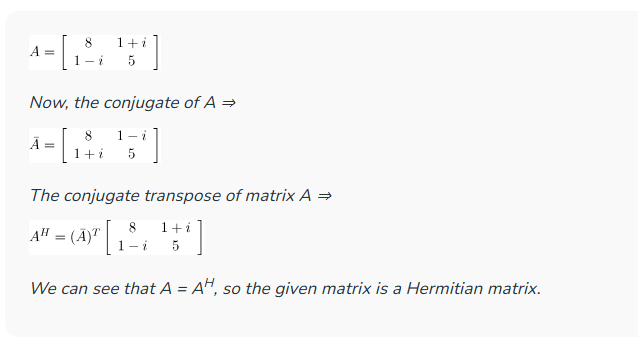

linalg.cholesky(a)[source]
Cholesky decomposition.

Return the Cholesky decomposition, L * L.H, of the square matrix a, where L is lower-triangular and .H is the conjugate transpose operator (which is the ordinary transpose if a is real-valued). a must be Hermitian (symmetric if real-valued) and positive-definite. No checking is performed to verify whether a is Hermitian or not. In addition, only the lower-triangular and diagonal elements of a are used. Only L is actually returned.



In [ ]:
# testing stuffs

# print(np.diag((-1,1,2,3)))
print(np.array(range(8)))

[0 1 2 3 4 5 6 7]


A [[ 0.68216792  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 1.38700849  2.37003808  0.          0.          0.          0.
   0.          0.        ]
 [ 0.18119636 -0.26458467  0.61553491  0.          0.          0.
   0.          0.        ]
 [-0.19515307 -0.29812798 -0.25234471  0.75198308  0.          0.
   0.          0.        ]
 [ 0.03006957  0.56724344  0.02649732 -0.1247821   0.78149941  0.
   0.          0.        ]
 [-0.10790823  0.03677496 -0.0944088  -0.19861443 -0.00773336  0.62569732
   0.          0.        ]
 [ 0.04343249 -0.21345447 -0.37028557 -0.23659122 -0.11681227 -0.14465044
   0.29789659  0.        ]
 [-0.41655683 -0.43478151  0.07777991  0.02291786 -0.07122611 -0.35873224
   0.0281703   0.55873999]]
Z [[-1.89094376 -0.73217207 -0.14984909 -1.14470411  0.58508253 -0.84236519
  -2.30060146 -0.29055105 -0.29666271 -0.91905494]
 [ 0.60765328 -2.03759966 -1.5191102   0.78120838  0.27899457 -0.64276265
  -1.80932675  0.74386482 -2

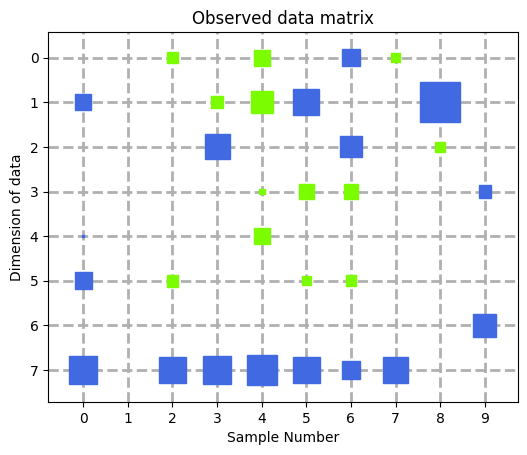

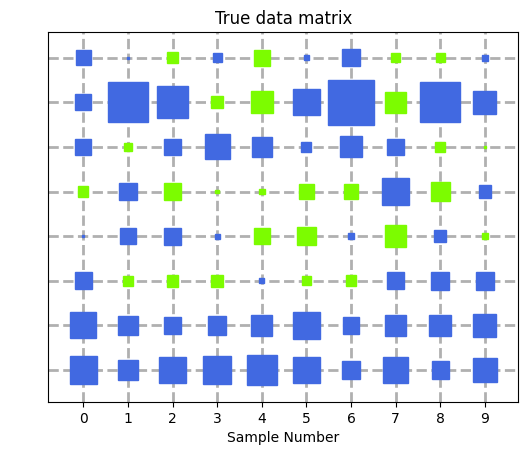

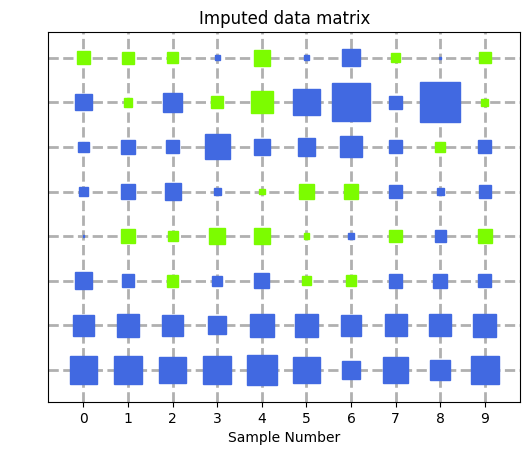

In [ ]:

mean = random.normal(random.PRNGKey(42), shape=(data_dim, 1))
cov = make_spd_matrix(n_dim=data_dim)

if not is_pos_def(cov):
  print(f"The covariance matrix is not positive definite. \n {cov}")
else:
  x_true = gauss_sample(mean, cov, sample_size)
  missing_idx = random.normal(random.PRNGKey(53), shape=(sample_size, data_dim)) < threshold_missing
  x_observed = jnp.copy(x_true)

# `at` is used in the extension jnp which is not part of np
  x_observed = x_observed.at[missing_idx].set(jnp.nan)
  x_imputed = gauss_impute(mean, cov, x_observed)

  x_observed0 = jnp.copy(x_true)
  x_observed0 = x_observed0.at[missing_idx].set(0)

  # Plot the data
  plot_hinton_data(
      x_observed0,
      "Observed data matrix",
      "gauss_impute_observed",
      graph_pos_ind=1,
  )
  plot_hinton_data(x_true, "True data matrix", "gauss_impute_truth", graph_pos_ind=2)
  plot_hinton_data(
      x_imputed,
      "Imputed data matrix",
      "gauss_impute_pred",
      graph_pos_ind=3,
  )
